In [16]:
import librosa
import numpy as np
import cv2
import glob

In [17]:
# load .wav and generate CQT-Spectrum, then save as .npy (直接存矩陣不存圖，就沒有resolution的問題)
def store_cqt_npy(fname):
    y, sr = librosa.load('Audio_Data/ch/'+fname)
    n_bins=84
    CQT = librosa.amplitude_to_db(np.abs(librosa.cqt(y, sr=sr, n_bins=n_bins)), ref=np.max)
    CQT = cv2.resize(CQT.astype('float'), (60, n_bins), interpolation = cv2.INTER_CUBIC)
    np.save('ch_cqt_npy/'+fname, CQT)

filename = glob.glob(r'Audio_Data/ch/*.wav')
for i in range(len(filename)):
    # mac
    # filename[i] = filename[i].split('/')[1]
    # window
    filename[i] = filename[i].split('\\')[1]
    store_cqt_npy(filename[i])    

In [18]:
# 讀取npy，總共1500筆
import random
from keras.utils import np_utils
x_list = []
y_list = []
filename_npy = glob.glob(r'ch_cqt_npy/*.npy')
# 洗牌一下，到時只要切最後一塊出來當test就好，比較方便不用用抽樣的
random.shuffle(filename_npy)
for i in range(len(filename_npy)):
    x_list.append(np.load(filename_npy[i]))
    # mac
    # y_list.append(filename_npy[i].split('/')[1][0])
    # window
    y_list.append(filename_npy[i].split('\\')[1][0])

In [19]:
len(x_list)

1500

In [20]:
# 1350做train、150做test
div = 1350
x_train = np.asarray(x_list[:div])
y_train = np.asarray(y_list[:div])
x_test = np.asarray(x_list[div:])
y_test = np.asarray(y_list[div:])
x_train = x_train.reshape(-1,84,60,1)
x_test = x_test.reshape(-1,84,60,1)

print(x_train.max(), x_train.min())
print(x_test.max(), x_test.min())

# normalized和1-hot
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

6.6417362551 -86.8690415758
3.1002722515 -86.0582852628


In [21]:
#%% 測試一下GPU是不是available
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#%% import package
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import SGD
from keras.datasets import mnist
from keras import optimizers
from keras.layers.advanced_activations import LeakyReLU

In [22]:
tf.test.is_gpu_available()

True

In [23]:
#%% model
model = Sequential()

input_shape = (84, 60, 1)

model.add(Conv2D(16, (7, 7), padding='same', input_shape=input_shape))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(32, (5, 5), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(LeakyReLU(0.1))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(128))
model.add(LeakyReLU(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.0005),
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 84, 60, 16)        800       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 84, 60, 16)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 42, 30, 16)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 42, 30, 16)        64        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 42, 30, 32)        12832     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 42, 30, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 21, 15, 32)        0         
__________

In [25]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping('val_acc', patience=15, verbose=1)

In [26]:
#%% fit model
model_history = model.fit(x_train, y_train, batch_size=128, epochs=100,
                          validation_data = (x_test, y_test),
                          shuffle = True,
                          callbacks=[early_stopping]
                         )

Train on 1350 samples, validate on 150 samples
Epoch 1/100
1350/1350 [==============================] - 3s 2ms/step - loss: 1.9392 - acc: 0.4007 - val_loss: 2.1618 - val_acc: 0.4400
Epoch 2/100
1350/1350 [==============================] - 1s 524us/step - loss: 0.6059 - acc: 0.8119 - val_loss: 2.4101 - val_acc: 0.4133
Epoch 3/100
1350/1350 [==============================] - 1s 524us/step - loss: 0.2666 - acc: 0.9244 - val_loss: 1.4841 - val_acc: 0.6333
Epoch 4/100
1350/1350 [==============================] - 1s 521us/step - loss: 0.1390 - acc: 0.9674 - val_loss: 0.5455 - val_acc: 0.8000
Epoch 5/100
1350/1350 [==============================] - 1s 519us/step - loss: 0.0852 - acc: 0.9830 - val_loss: 0.2117 - val_acc: 0.9267
Epoch 6/100
1350/1350 [==============================] - 1s 521us/step - loss: 0.0500 - acc: 0.9948 - val_loss: 0.1444 - val_acc: 0.9400
Epoch 7/100
1350/1350 [==============================] - 1s 524us/step - loss: 0.0341 - acc: 0.9985 - val_loss: 0.1276 - val_acc: 0.9

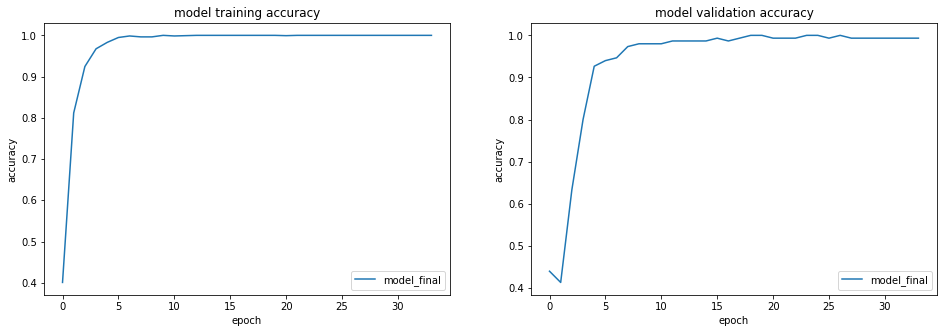

In [27]:
# 作圖
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1,2,1)
plt.plot(model_history.history["acc"])

plt.title("model training accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

ax2 = fig.add_subplot(1,2,2)
plt.plot(model_history.history["val_acc"])

plt.title("model validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["model_final"], loc = "best")

plt.show()

In [28]:
# score
score = model.evaluate(x_test, y_test, batch_size=10000)
print("Loss: %f" %score[0])
print("testing accuracy: %f" %(score[1]*100))

150/150 [==============================] - 0s 1ms/step
Loss: 0.011612
testing accuracy: 99.333334


In [29]:
#%% 儲存model
model.save('CH_CQT_CNN.h5')